In [4]:
import os 
import pandas as pd 
import sys 
import re 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path,'..','..'))  # '..','..','..'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from pipeline.plotting.TS_analysis import plot_TS
from pipeline.plotting.plotting_boxplot_metrics import plot_boxplot_on_metric
from experiences.convert_df_to_latex import dataframe_to_latex,parse_index_exp1_2,parse_index_exp4,tackle_trial_j,update_df_metrics,load_csv
from experiences.common_results import dic_exp_to_names,find_baseline,dic_trials
from experiences.common_results import dic_exp_to_names,dic_trials
from experiences.get_desagregated_plot import get_desagregated_gains
import os 
import pandas as pd 
from pipeline.plotting.TS_analysis import plot_TS

folder_path = 'save/K_fold_validation/training_wo_HP_tuning'  # '../../save'


def change_legend(row):
    if row.legend_group == 'Other Methods':
        if 'early_fusion' in row.name:
            return 'Early Fusion Other Methods '
        elif 'late_fusion' in row.name:
            return 'Late Fusion Other Methods '
        else:
            return row.legend_group
    else:
        return row.legend_group

def reduce_id(x):
    x = x.replace('late_fusion_','L_')
    x = x.replace('early_fusion_','E_')
    x = x.replace('backbone','BB')
    return x 

def local_tackle_trial_for_distrib(folder_path,dic_exp_to_names,exp_i,trials,metrics,agg):
    L_metrics = []
    for trial_j in trials:
        if (exp_i == 'Exp3_bike_15min_h4') and ('STAEformer_bike_out_calendar__e50_h4' in trial_j or 'STAEformer_bike_out_calendar__e80_h4' in trial_j):
            exp_i_tmp = 'Exp4_15min'
            # trial_j = 'STAEformer_bike_out_calendar__e200_h4'
        elif exp_i == 'Exp4_15min_h1':
            exp_i_tmp = 'Exp4_15min'
        else:
            exp_i_tmp = exp_i
        L_metrics = tackle_trial_j(folder_path,dic_exp_to_names,L_metrics,exp_i_tmp,trial_j,metrics,agg_bool=agg,plot_losses=False)

    df_metrics_all = pd.concat(L_metrics)
    return df_metrics_all


def local_plot_boxplot_metrics(experiences,metrics,folder_path,dic_exp_to_names,palette,legend_groups,configs_to_keep =None,fusion_type_to_keep =None,local_reduce_id = None):
    dic_df_horizons = {}
    dic_df_horizons_init = {}
    for exp_i in experiences:

        trials = dic_trials[exp_i]
        print(f"\n------------------ {exp_i} ---")

        df_metrics_all = local_tackle_trial_for_distrib(folder_path,dic_exp_to_names,exp_i,trials,metrics,agg=False)


        horizons = list(set([c.split('_')[-1][1:] for c in df_metrics_all.columns]))
        dic_df_horizons[exp_i] = {}
        dic_df_horizons_init[exp_i] = {}
        for horizon in horizons:
            
            print('\n----------------')
            print(f"Horizon: {horizon}")
            df_horizon = df_metrics_all[[c for c in df_metrics_all.columns if c.endswith(f"_h{horizon}")]].dropna()

            df_horizon = update_df_metrics(df_horizon,exp_i)
            df_horizon['legend_group'] = df_horizon.apply(change_legend,axis = 1)


            df_horizon_init = df_horizon.copy()
            if fusion_type_to_keep is not None:
                df_horizon = df_horizon[df_horizon.index.str.contains(fusion_type_to_keep)| 
                                                  (df_horizon['legend_group'] == 'Baseline')
                                                  ].copy()

            if configs_to_keep is not None: 
                df_horizon = df_horizon[df_horizon['id'].isin(configs_to_keep)].copy()
                df_horizon['id'] = df_horizon['id'].apply(reduce_id)

            if local_reduce_id is not None:
                df_horizon['id'] = df_horizon['id'].apply(local_reduce_id)
            

            dic_df_horizons[exp_i][horizon] = df_horizon
            dic_df_horizons_init[exp_i][horizon] = df_horizon_init
            for metric in metrics: 
                plot_boxplot_on_metric(df_horizon, metric_i=metric, xaxis_label="Config", legend_group='legend_group', width=800, height=600, 
                                            save_path=None,palette =palette ,legend_groups =legend_groups )
        
    return dic_df_horizons_init,dic_df_horizons





def get_table_of_performance(dic_exp_to_names,exp_i,trials,caption_i,label,parser,
                             folder_path=None,
                             metrics = ['rmse','mae','mase'],
                             ):

    if folder_path is None:
        folder_path = 'save/K_fold_validation/training_wo_HP_tuning' # '../../


    df_metrics_all = local_tackle_trial_for_distrib(folder_path,dic_exp_to_names,exp_i,trials,metrics,agg=True)

    horizons = list(set([c[0].split('_')[-1][1:] for c in df_metrics_all.columns]))
    for horizon in horizons:
        df_horizon = df_metrics_all[[c for c in df_metrics_all.columns if c[0].endswith(f"_h{horizon}")]].dropna()

        globals()[f"df_metrics_{exp_i}_h{horizon}"] = df_horizon.sort_values(by=[(f'rmse_h{horizon}','mean')])

        baseline_index = find_baseline(exp_i,h=horizon)
        for c in globals()[f"df_metrics_{exp_i}_h{horizon}"].columns:
            if 'mean' == c[1]:
                globals()[f"df_metrics_{exp_i}_h{horizon}"][c] = globals()[f"df_metrics_{exp_i}_h{horizon}"][c].apply(lambda x: f"{round(x,2)} ({round(100*(-1+x/globals()[f'df_metrics_{exp_i}_h{horizon}'].loc[baseline_index,c]),2)}\%)")
        
        display(globals()[f"df_metrics_{exp_i}_h{horizon}"])

       
        print(dataframe_to_latex(globals()[f"df_metrics_{exp_i}_h{horizon}"], caption_i, label, parse_index_exp4))




# Graphique pour 'Bike-Prediction' avec données contextuelles

In [4]:
import os
os.listdir('..')
os.path.exists('../ref_lines.csv')

True

In [2]:
# ---- Plot Desagregated Gains : ----

# exp: 
#  'Exp3_bike_15min_h4',     # prediction Bike-out / Subway-out Weathr (h4)
#  'Exp4',                   # prediction bike-out / subway-in, subway-out (h1) avec freq = 60min 

# Prediction Bike-out : 
#  'Exp4_15min',             # prediction Bike-out / subway-in,subway-out (h4)
#  'Exp4_15min_h1',          # prediction Bike-out / subway-in,subway-out (h1)


# Seules configurations commune entre les deux expériences: 
configs_to_keep = ['Baseline',
 'In24_ctxIn24_adp16_adpQ0',
 'In24_ctxIn24_adp16_adpQ24',
 'In24_ctxIn8_adp16_adpQ0',
 'In24_ctxIn8_adp16_adpQ24'
]
fusion_type_to_keep = 'late'  # 'early'
experiences = ['Exp4_15min','Exp4_15min_h1'] #['Exp3','Exp3_bike_15min_h4','Exp4','Exp4_15min_h1','Exp4_15min']
metrics = ['mase','rmse']
palette = None
legend_groups = None
comparison_on_rainy_events = False
station_clustering = True
save_folder_path = 'save'
range_k = range(1,6)

dic_df_horizons_init,dic_df_horizons =  local_plot_boxplot_metrics(experiences,metrics,folder_path,dic_exp_to_names,palette,legend_groups,configs_to_keep=configs_to_keep,fusion_type_to_keep =fusion_type_to_keep)

for exp_i in experiences:
    horizon = 1 if exp_i == 'Exp4_15min_h1' else 4
    trials = [f'STAEformer_bike_out_subway_in_subway_out_calendar_{pos}_fusion_CrossAttnBackBone_InEmb{InEmb}_ctxInEmb{Ctx}_adp{Adp}_adpQ{Q}__e80_h{horizon}'
            for pos,InEmb,Ctx,Adp,Q in [
                                    ('late',24,24,16,0),
                                    ('late',24,24,16,24),
                                    ('late',24,8,16,0),
                                    ('late',24,8,16,24),
                                    # ('early',24,8,16,0),
                                    # ('late',24,24,16,24),
                                    # ('late',12,24,16,0),
                                ]]+ [f'STAEformer_bike_out_calendar__e80_h{horizon}']

    dic_trials_i = {exp_i: trials}
    dic_exp_to_names_i = {exp_i: dic_exp_to_names[exp_i]}
    horizons = [4] if exp_i == 'Exp4_15min' else [1]
    get_desagregated_gains(dic_exp_to_names_i,dic_trials_i,horizons,comparison_on_rainy_events,range_k,station_clustering,save_folder_path,save_bool=True)


------------------ Exp4_15min ---

----------------
Horizon: 4


Loading BokehJS ...

Loading BokehJS ...


------------------ Exp4_15min_h1 ---

----------------
Horizon: 1


Loading BokehJS ...

Loading BokehJS ...

Exp4_15min
Trial id Ref:  STAEformer_bike_out_calendar__e80_h4_bis
Trial id to test: 
STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ0__e80_h4_bis
STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e80_h4_bis
STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0__e80_h4_bis
STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ24__e80_h4_bis
Trial ID 1:  _STAEformer_bike_out_calendar__e80_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ0__e80_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp4_15min/bike_out_STAEformer/best_models/STAEformer_bike_out_calendar__e80_h4_bis1_f5.pkl
-----------------

KeyboardInterrupt: 

# Get Table of performances: 

In [3]:
# Get Data from saved csv files:  

caption_i = f"Prediction of shared-bike pick-up at horizon with STAEformer using contextual data 'Subway-in' and 'Subway-out' according to different Integration Strategies. Metrics are averaged over 5 runs."
parser = parse_index_exp4
label = "exp4_bike_hetero_15min"


experiences = ['Exp4_15min_h1','Exp4_15min'] # 'Exp3','Exp3_bike_15min_h4','Exp4', 'Exp4_15min_h1','Exp4_15min'
for exp_i in experiences:

    print(f"\n------------------ {exp_i} ---")

    horizon = 4 if exp_i == 'Exp4_15min' else 1
    trials = [f'STAEformer_bike_out_subway_in_subway_out_calendar_{pos}_fusion_CrossAttnBackBone_InEmb{InEmb}_ctxInEmb{Ctx}_adp{Adp}_adpQ{Q}__e80_h{horizon}'
                    for pos,InEmb,Ctx,Adp,Q in [
                                ('late',24,24,16,0),
                                ('late',24,24,16,24),
                                ('late',24,8,16,0),
                                ('late',24,8,16,24),

                            ]]+ [f'STAEformer_bike_out_calendar__e80_h{horizon}'] 

    get_table_of_performance(dic_exp_to_names,exp_i,trials,caption_i,label,parser,
                             )




------------------ Exp4_15min_h1 ---


rmse_h1            \
                                                             mean       std   
STAEformer_bike_out_subway_in_subway_out_calend...   4.3 (-0.1\%)  0.014277   
STAEformer_bike_out_calendar__e80_h1                 4.31 (0.0\%)  0.026217   
STAEformer_bike_out_subway_in_subway_out_calend...  4.31 (0.01\%)  0.013055   
STAEformer_bike_out_subway_in_subway_out_calend...  4.33 (0.48\%)  0.010709   
STAEformer_bike_out_subway_in_subway_out_calend...  4.34 (0.68\%)  0.031022   

                                                            mae_h1            \
                                                              mean       std   
STAEformer_bike_out_subway_in_subway_out_calend...  2.78 (-0.31\%)  0.016441   
STAEformer_bike_out_calendar__e80_h1                  2.79 (0.0\%)  0.014120   
STAEformer_bike_out_subway_in_subway_out_calend...  2.78 (-0.25\%)  0.009006   
STAEformer_bike_out_subway_in_subway_out_calend...    2.8 (0.37\%)  0.014958   
STAEformer_bike_out_subway_in_subway_out_calend...    2.8 (0.25\%)  0.017826   

                                                           mase_h1            
                                                              mean       std  
STAEformer_bike_out_subway_in_subway_out_calend...   0.72 (-0.3\%)  0.004266  
STAEformer_bike_out_calendar__e80_h1                  0.72 (0.0\%)  0.003665  
STAEformer_bike_out_subway_in_subway_out_calend...  0.72 (-0.25\%)  0.002334  
STAEformer_bike_out_subway_in_subway_out_calend...   0.73 (0.37\%)  0.003876  
STAEformer_bike_out_subway_in_subway_out_calend...   0.73 (0.25\%)  0.004629

\begin{table}[!htb]
    \centering
    \caption{Prediction of shared-bike pick-up at horizon with STAEformer using contextual data 'Subway-in' and 'Subway-out' according to different Integration Strategies. Metrics are averaged over 5 runs.}
    \label{tab:exp4_bike_hetero_15min}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{lllllcccccc}}
        \toprule
        Type & InEmb & ctxInEmb & adp & adpQ & \multicolumn{2}{c}{ RMSE (h1) } & \multicolumn{2}{c}{ MAE (h1) } & \multicolumn{2}{c}{ MASE (h1) } \\
        \cmidrule(lr){1-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} \cmidrule(lr){10-11}
         &  &  &  &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        CrossAttnBackBone & 24 & 24 & 16 & 24 & 4.3 (-0.1\%) & 0.0143 & 2.78 (-0.31\%) & 0.0164 & 0.72 (-0.3\%) & 0.0043 \\
        CrossAttnBackBone & 24 & 24 & 16 & 0 & 4.31 (0.01\%) & 0.0131 & 2.78 (-0.25\%) & 0.0090 & 0.72 (-0.25\%) & 0.0023 \\
        CrossAttnBackBone & 24 & 8 & 16 & 0 & 4.33 (0.48\%) & 0.0107 & 2

rmse_h4            \
                                                              mean       std   
STAEformer_bike_out_subway_in_subway_out_calend...  4.85 (-1.53\%)  0.032139   
STAEformer_bike_out_subway_in_subway_out_calend...    4.9 (-0.6\%)  0.039494   
STAEformer_bike_out_subway_in_subway_out_calend...  4.93 (-0.01\%)  0.027345   
STAEformer_bike_out_subway_in_subway_out_calend...  4.93 (-0.01\%)  0.050071   
STAEformer_bike_out_calendar__e80_h4                  4.93 (0.0\%)  0.035423   

                                                            mae_h4            \
                                                              mean       std   
STAEformer_bike_out_subway_in_subway_out_calend...  3.05 (-1.06\%)  0.019391   
STAEformer_bike_out_subway_in_subway_out_calend...  3.06 (-0.52\%)  0.017883   
STAEformer_bike_out_subway_in_subway_out_calend...   3.08 (0.07\%)  0.027472   
STAEformer_bike_out_subway_in_subway_out_calend...  3.08 (-0.06\%)  0.020051   
STAEformer_bike_out_calendar__e80_h4                  3.08 (0.0\%)  0.014814   

                                                           mase_h4            
                                                              mean       std  
STAEformer_bike_out_subway_in_subway_out_calend...  0.79 (-1.06\%)  0.005035  
STAEformer_bike_out_subway_in_subway_out_calend...   0.8 (-0.52\%)  0.004647  
STAEformer_bike_out_subway_in_subway_out_calend...    0.8 (0.07\%)  0.007128  
STAEformer_bike_out_subway_in_subway_out_calend...   0.8 (-0.06\%)  0.005215  
STAEformer_bike_out_calendar__e80_h4                   0.8 (0.0\%)  0.003840

\begin{table}[!htb]
    \centering
    \caption{Prediction of shared-bike pick-up at horizon with STAEformer using contextual data 'Subway-in' and 'Subway-out' according to different Integration Strategies. Metrics are averaged over 5 runs.}
    \label{tab:exp4_bike_hetero_15min}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{lllllcccccc}}
        \toprule
        Type & InEmb & ctxInEmb & adp & adpQ & \multicolumn{2}{c}{ RMSE (h4) } & \multicolumn{2}{c}{ MAE (h4) } & \multicolumn{2}{c}{ MASE (h4) } \\
        \cmidrule(lr){1-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} \cmidrule(lr){10-11}
         &  &  &  &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        CrossAttnBackBone & 24 & 8 & 16 & 24 & 4.85 (-1.53\%) & 0.0321 & 3.05 (-1.06\%) & 0.0194 & 0.79 (-1.06\%) & 0.0050 \\
        CrossAttnBackBone & 24 & 24 & 16 & 24 & 4.9 (-0.6\%) & 0.0395 & 3.06 (-0.52\%) & 0.0179 & 0.8 (-0.52\%) & 0.0046 \\
        CrossAttnBackBone & 24 & 24 & 16 & 0 & 4.93 (-0.01\%) & 0.0273 

# Graphique pour Subway-In prediction avec NetMob 

In [2]:

dic_configs_to_keep = {
    # 'Exp6_subway_netmob': ['Baseline',
    #                                             'In24_ctxIn12_adp16_adpQ24_GM_WW',
    #                                             'In24_ctxIn12_adp16_adpQ24_n100_GM_WW',
    #                                             'In24_ctxIn24_adp16_adpQ24_GM_WW',
    #                                             'In24_ctxIn24_adp16_adpQ24_n100_GM_WW',
    #                                             'In24_ctxIn48_adp16_adpQ24_GM_WW',
    #                                             'In24_ctxIn48_adp16_adpQ24_n100_GM_WW',
    #                                             'In24_ctxIn8_adp16_adpQ24_GM_WW',
    #                                             'In24_ctxIn8_adp16_adpQ24_n100_GM_WW'
    #                                             ],
                        'Exp6_bike_netmob': ['Baseline',
                                            'In24_ctxIn24_adp16_adpQ24_agg100_GM',
                                            'In24_ctxIn24_adp16_adpQ24_agg100_WW',
                                            'In24_ctxIn24_adp16_adpQ24_agg100_GM_WW',
                                            'In24_ctxIn24_adp16_adpQ24_agg50_GM',
                                            'In24_ctxIn24_adp16_adpQ24_agg50_WW',
                                            'In24_ctxIn24_adp16_adpQ24_agg50_GM_WW',
                                            # 'In24_ctxIn24_adp16_adpQ24_n100_Deezer_GM_GM_D',
                                            # 'In24_ctxIn24_adp16_adpQ24_n100_Deezer_Deezer_GM_D',
                                            # 'In24_ctxIn24_adp16_adpQ24_n100_Deezer_Deezer_D_GM',
                                            ]
                            
                        }
fusion_type_to_keep = None #'late'  # 'early' #None
experiences = ['Exp6_subway_netmob']# ,'Exp6_bike_netmob'] #,'Exp6_subway_netmob'] 
metrics = ['mase','rmse']
palette = None
legend_groups = None
comparison_on_rainy_events = False
station_clustering = True
save_folder_path = 'save'
range_k = range(1,6)
horizons = [1,4]

import itertools
L_aggIris = ['', '_aggIris100_','_aggIris50_', '_aggIris100','_aggIris50']
L_trial = ['','_trial2']
apps = ['Google_Maps','Web_Weather','Instagram','Deezer']
combinations_apps = ['_'.join(list(comb)) if len(comb) > 1 else list(comb)[0] for i in range(1, len(apps) + 1) for comb in itertools.permutations(apps, i)] + ['']

pos_fusion = 'late'  # 'early'

## Prediction Bike-Out 


------------------ Exp6_bike_netmob ---

----------------
Horizon: 1


Loading BokehJS ...

Loading BokehJS ...


----------------
Horizon: 4


Loading BokehJS ...

Loading BokehJS ...

Exp6_bike_netmob
   Horizon:  4
   Baseline:  STAEformer_bike_out_calendar__e150_h4
Trial id Ref:  STAEformer_bike_out_calendar__e150_h4_bis
Trial id to test: 
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather__e150_h4_bis
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Google_Maps__e150_h4_bis
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris50_Web_Weather_Google_Maps__e150_h4_bis
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris50_Google_Maps__e150_h4_bis
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris50_Web_Weather__e150_h4_bis
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather_Google_Map

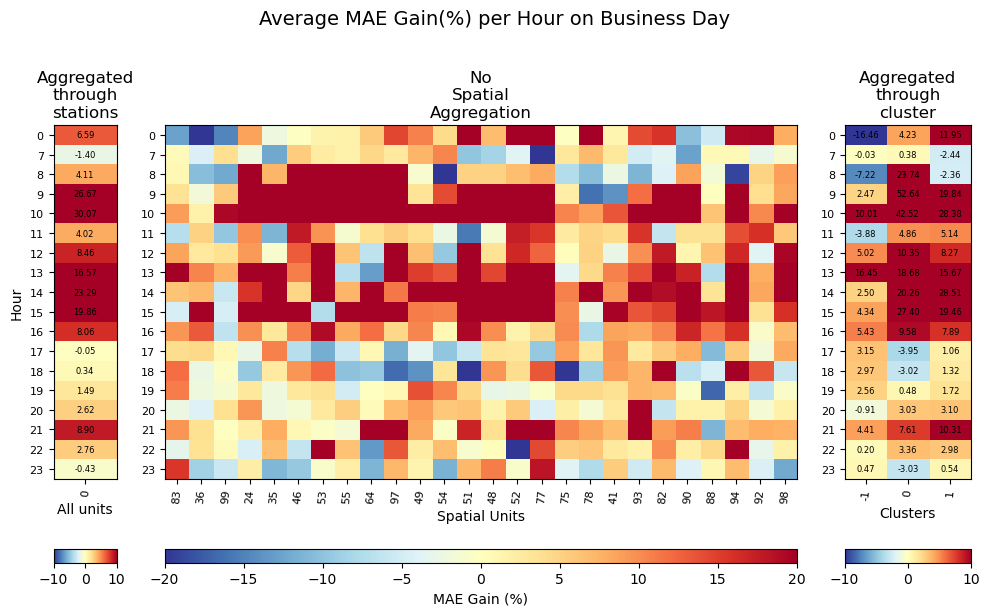

Figure saved in save/plot/Exp6_bike_netmob/mae/desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather__e150_h4_bis_gain.pdf
Figure saved in desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather__e150_h4_bis.pdf

STAEformer_bike_out_calendar__e150_h4_:   All Steps RMSE = 5.09702, MAE = 3.33263, MASE = 0.56363, MAPE = 46.69191
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather__e150_h4_:   All Steps RMSE = 5.63201, MAE = 3.66388, MASE = 0.61966, MAPE = 47.18871

Trial ID 1:  _STAEformer_bike_out_calendar__e150_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Google_Maps__e150_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validati

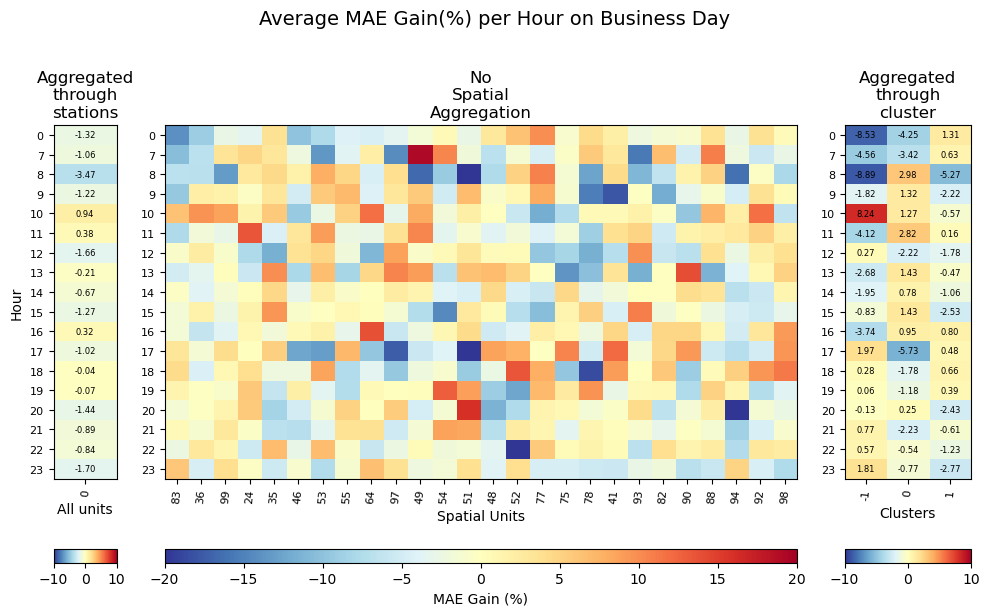

Figure saved in save/plot/Exp6_bike_netmob/mae/desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Google_Maps__e150_h4_bis_gain.pdf
Figure saved in desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Google_Maps__e150_h4_bis.pdf

STAEformer_bike_out_calendar__e150_h4_:   All Steps RMSE = 5.09702, MAE = 3.33263, MASE = 0.56363, MAPE = 46.69191
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather__e150_h4_:   All Steps RMSE = 5.63201, MAE = 3.66388, MASE = 0.61966, MAPE = 47.18871
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Google_Maps__e150_h4_:   All Steps RMSE = 5.10720, MAE = 3.33078, MASE = 0.56332, MAPE = 46.53492

Trial ID 1:  _STAEformer_bike_out_calendar__e150_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out

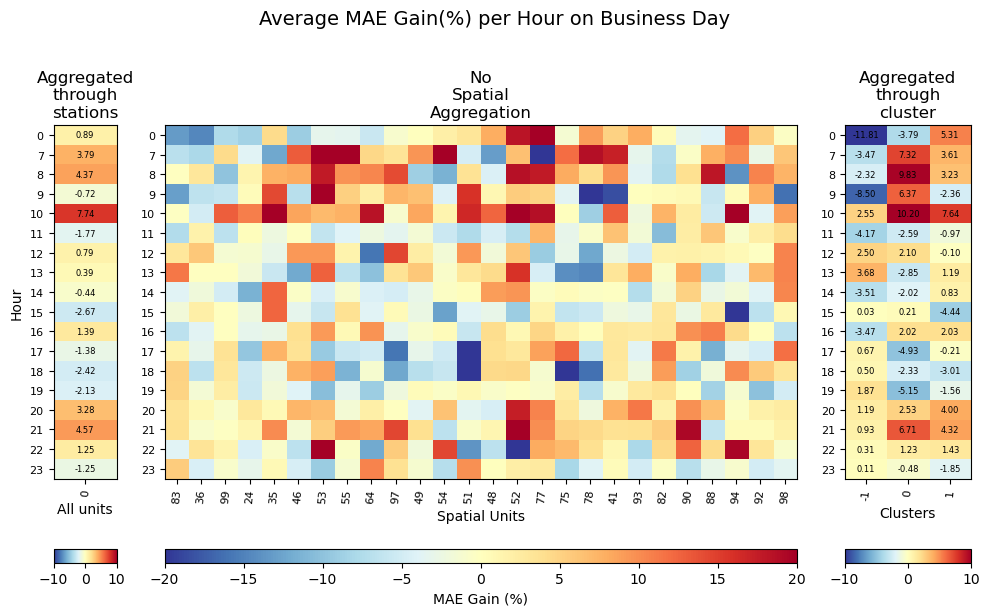

Figure saved in save/plot/Exp6_bike_netmob/mae/desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris50_Web_Weather_Google_Maps__e150_h4_bis_gain.pdf
Figure saved in desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris50_Web_Weather_Google_Maps__e150_h4_bis.pdf

STAEformer_bike_out_calendar__e150_h4_:   All Steps RMSE = 5.09702, MAE = 3.33263, MASE = 0.56363, MAPE = 46.69191
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather__e150_h4_:   All Steps RMSE = 5.63201, MAE = 3.66388, MASE = 0.61966, MAPE = 47.18871
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Google_Maps__e150_h4_:   All Steps RMSE = 5.10720, MAE = 3.33078, MASE = 0.56332, MAPE = 46.53492
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_I

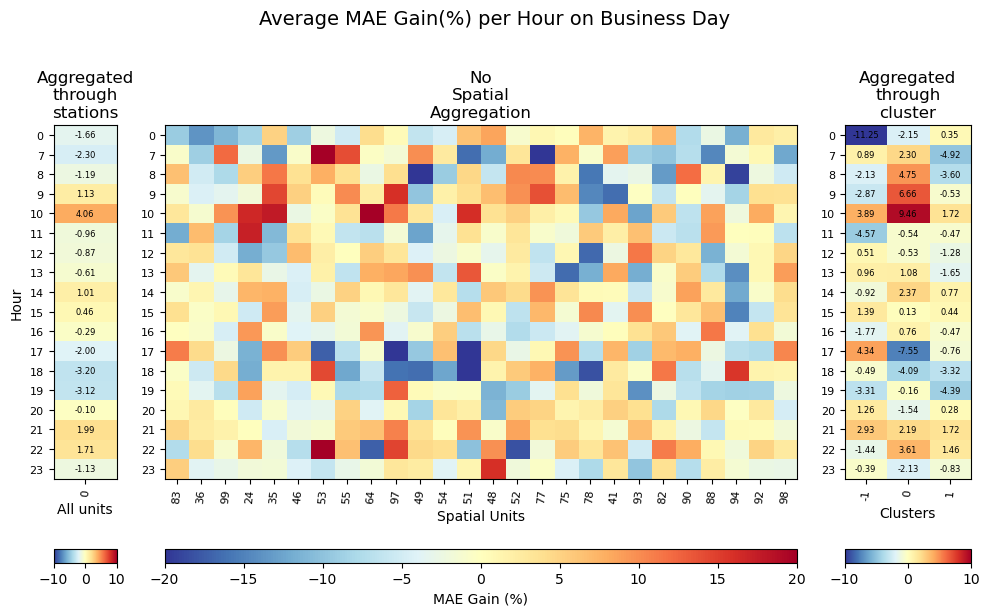

Figure saved in save/plot/Exp6_bike_netmob/mae/desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris50_Google_Maps__e150_h4_bis_gain.pdf
Figure saved in desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris50_Google_Maps__e150_h4_bis.pdf

STAEformer_bike_out_calendar__e150_h4_:   All Steps RMSE = 5.09702, MAE = 3.33263, MASE = 0.56363, MAPE = 46.69191
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather__e150_h4_:   All Steps RMSE = 5.63201, MAE = 3.66388, MASE = 0.61966, MAPE = 47.18871
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Google_Maps__e150_h4_:   All Steps RMSE = 5.10720, MAE = 3.33078, MASE = 0.56332, MAPE = 46.53492
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_

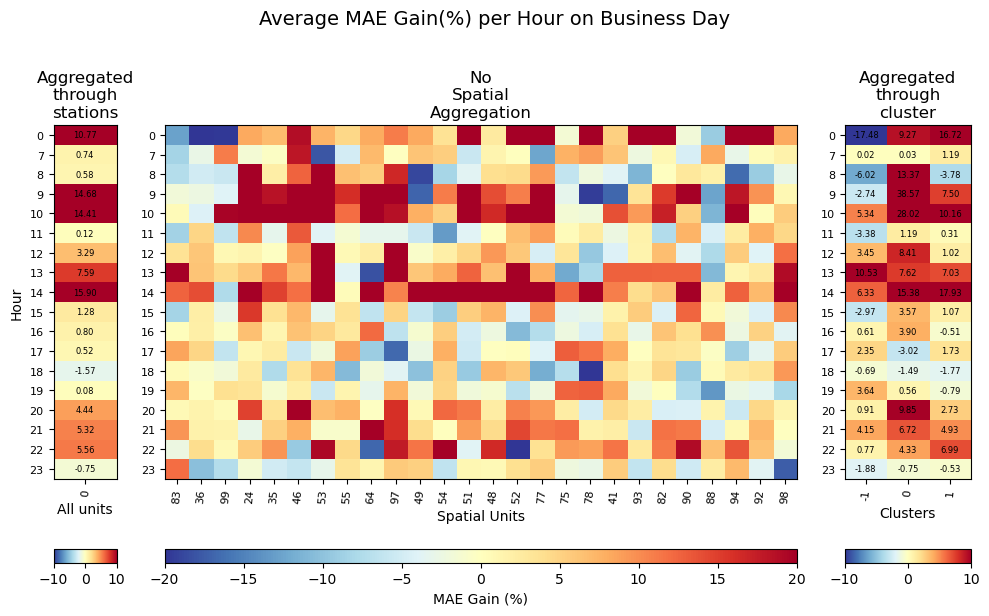

Figure saved in save/plot/Exp6_bike_netmob/mae/desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris50_Web_Weather__e150_h4_bis_gain.pdf
Figure saved in desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris50_Web_Weather__e150_h4_bis.pdf

STAEformer_bike_out_calendar__e150_h4_:   All Steps RMSE = 5.09702, MAE = 3.33263, MASE = 0.56363, MAPE = 46.69191
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather__e150_h4_:   All Steps RMSE = 5.63201, MAE = 3.66388, MASE = 0.61966, MAPE = 47.18871
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Google_Maps__e150_h4_:   All Steps RMSE = 5.10720, MAE = 3.33078, MASE = 0.56332, MAPE = 46.53492
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_

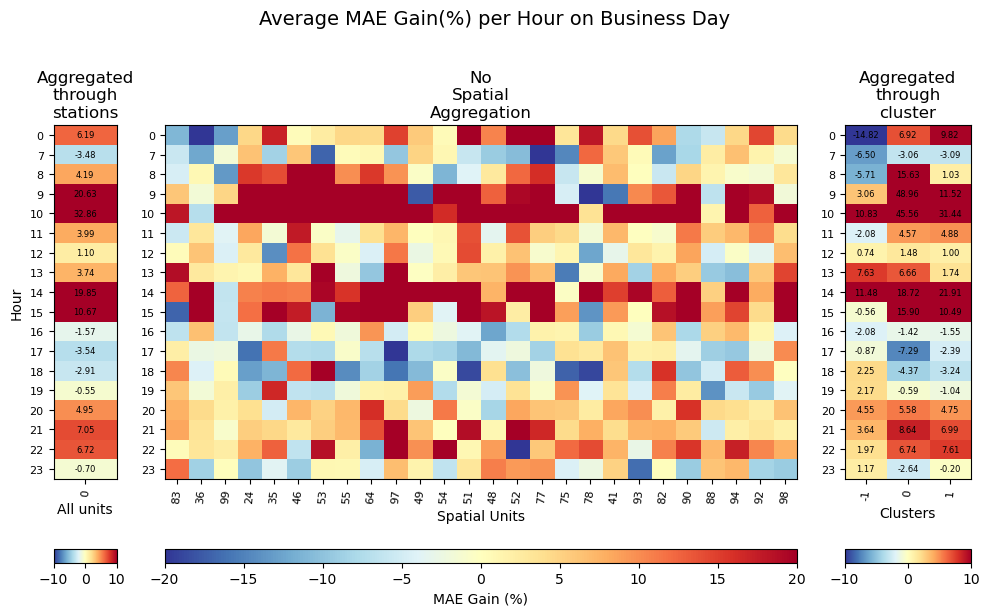

Figure saved in save/plot/Exp6_bike_netmob/mae/desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather_Google_Maps__e150_h4_bis_gain.pdf
Figure saved in desag_STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather_Google_Maps__e150_h4_bis.pdf

STAEformer_bike_out_calendar__e150_h4_:   All Steps RMSE = 5.09702, MAE = 3.33263, MASE = 0.56363, MAPE = 46.69191
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Web_Weather__e150_h4_:   All Steps RMSE = 5.63201, MAE = 3.66388, MASE = 0.61966, MAPE = 47.18871
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100_Google_Maps__e150_h4_:   All Steps RMSE = 5.10720, MAE = 3.33078, MASE = 0.56332, MAPE = 46.53492
STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone

In [35]:
from experiences.common_results import find_baseline

exp_i = 'Exp6_bike_netmob'
epochs = 150 # 80
mode_choice = 'bike_out_netmob_POIs'
dic_df_horizons_init,dic_df_horizons =  local_plot_boxplot_metrics([exp_i],metrics,folder_path,dic_exp_to_names,palette,legend_groups,configs_to_keep=dic_configs_to_keep[exp_i],fusion_type_to_keep =fusion_type_to_keep)



for horizon in horizons:
    config_cross_attn = [f'InEmb{InEmb}_ctxInEmb{Ctx}_adp{Adp}_adpQ{Q}'
                for InEmb,Ctx,Adp,Q in [
                                (24,24,16,0),
                                (24,24,16,24),
                                (24,8,16,0),
                                (24,8,16,24),
                                ]]
    


    start = f"STAEformer_{mode_choice}_calendar_{pos_fusion}_fusion_"

    end = f"__e{epochs}_h{horizon}"

    trials = [start + 'CrossAttnBackBone_'+  element[0] + element[1] + element[2] + end for element in itertools.product(config_cross_attn,L_aggIris,combinations_apps)]
    
    baseline = find_baseline(exp_i,h=horizon)
    trials =  trials + [baseline] if baseline not in trials else trials


    possible_trials = set(trials) & set([c.split('_bis')[0] for c in list(dic_df_horizons[exp_i][str(horizon)].index)])
    
    dic_trials_i = {exp_i: possible_trials}
    dic_exp_to_names_i = {exp_i: dic_exp_to_names[exp_i]}
    get_desagregated_gains(dic_exp_to_names_i,dic_trials_i,[horizon],comparison_on_rainy_events,range_k,station_clustering,save_folder_path,save_bool=True)

    # Display Latex Table:
    caption_i = f"Prediction of shared-bike pick-up at horizon (h{horizon}) with STAEformer using contextual data NetMob (mobile-phone app) according to different integration strategies. Metrics are averaged over 5 runs."
    parser = parse_index_exp4
    label = "exp4_bike_netmob_15min"
    
    get_table_of_performance(dic_exp_to_names,exp_i,possible_trials,caption_i,label,parser,)
    # --- 
    

In [6]:
dic_df_horizons_init['Exp6_subway_netmob']['4']

,mase,rmse,id,legend_group
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e150_h4_bis1,0.844745,48.455063,In24_ctxIn24_adp16_adpQ24_GM_WW,CrossAttn_GM_WW
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e150_h4_bis2,0.765000,40.321796,In24_ctxIn24_adp16_adpQ24_GM_WW,CrossAttn_GM_WW
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e150_h4_bis3,0.840785,44.975132,In24_ctxIn24_adp16_adpQ24_GM_WW,CrossAttn_GM_WW
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e150_h4_bis4,0.797025,42.787197,In24_ctxIn24_adp16_adpQ24_GM_WW,CrossAttn_GM_WW
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e150_h4_bis5,0.827896,44.715046,In24_ctxIn24_adp16_adpQ24_GM_WW,CrossAttn_GM_WW
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb12_adp16_adpQ24__e150_h4_bis1,0.839363,47.480381,In24_ctxIn12_adp16_adpQ24_GM_WW,CrossAttn_GM_WW
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb12_adp16_adpQ24__e150_h4_bis2,0.851069,47.877148,In24_ctxIn12_adp16_adpQ24_GM_WW,CrossAttn_GM_WW
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb12_adp16_adpQ24__e150_h4_bis3,0.843382,46.978470,In24_ctxIn12_adp16_adpQ24_GM_WW,CrossAttn_GM_WW
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb12_adp16_adpQ24__e150_h4_bis4,0.802985,43.594955,In24_ctxIn12_adp16_adpQ24_GM_WW,CrossAttn_GM_WW
STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb12_adp16_adpQ24__e150_h4_bis5,0.807736,43.680229,In24_ctxIn12_adp16_adpQ24_GM_WW,CrossAttn_GM_WW


# Prediction Subway  with NetMob 

In [21]:
dic_df_horizons['Exp6_subway_netmob']['1']['id'].index

Index(['STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb48_adp16_adpQ24_aggIris100__e150_h1_bis1',
       'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb48_adp16_adpQ24_aggIris100__e150_h1_bis2',
       'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb48_adp16_adpQ24_aggIris100__e150_h1_bis3',
       'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb48_adp16_adpQ24_aggIris100__e150_h1_bis4',
       'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb48_adp16_adpQ24_aggIris100__e150_h1_bis5',
       'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100__e150_h1_bis1',
       'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100__e150_h1_bis2',
       'STAEformer_subway_i

In [26]:
df_metrics_all = local_tackle_trial_for_distrib(folder_path,dic_exp_to_names,exp_i,trials,metrics,agg=True)
df_metrics_all

mase_h1            \
                                                        mean       std   
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.678363  0.023354   
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.688558  0.022065   
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.677517  0.009615   
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.679581  0.007971   
STAEformer_subway_in_netmob_POIs_calendar_late_...       NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...       NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...       NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...       NaN       NaN   
STAEformer_subway_in_calendar__e150_h4                   NaN       NaN   

                                                      rmse_h1            \
                                                         mean       std   
STAEformer_subway_in_netmob_POIs_calendar_late_...  35.935966  1.445708   
STAEformer_subway_in_netmob_POIs_calendar_late_...  36.459478  1.345812   
STAEformer_subway_in_netmob_POIs_calendar_late_...  35.736149  0.711533   
STAEformer_subway_in_netmob_POIs_calendar_late_...  35.927058  0.716963   
STAEformer_subway_in_netmob_POIs_calendar_late_...        NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...        NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...        NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...        NaN       NaN   
STAEformer_subway_in_calendar__e150_h4                    NaN       NaN   

                                                     mase_h4            \
                                                        mean       std   
STAEformer_subway_in_netmob_POIs_calendar_late_...       NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...       NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...       NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...       NaN       NaN   
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.838512  0.029944   
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.830678  0.029370   
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.827528  0.007292   
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.813047  0.029798   
STAEformer_subway_in_calendar__e150_h4              0.810451  0.036620   

                                                      rmse_h4            
                                                         mean       std  
STAEformer_subway_in_netmob_POIs_calendar_late_...        NaN       NaN  
STAEformer_subway_in_netmob_POIs_calendar_late_...        NaN       NaN  
STAEformer_subway_in_netmob_POIs_calendar_late_...        NaN       NaN  
STAEformer_subway_in_netmob_POIs_calendar_late_...        NaN       NaN  
STAEformer_subway_in_netmob_POIs_calendar_late_...  46.159889  3.189010  
STAEformer_subway_in_netmob_POIs_calendar_late_...  46.046899  2.295588  
STAEformer_subway_in_netmob_POIs_calendar_late_...  45.372811  0.988276  
STAEformer_subway_in_netmob_POIs_calendar_late_...  44.826180  2.316863  
STAEformer_subway_in_calendar__e150_h4              43.730510  2.225578

In [25]:
from experiences.common_results import find_baseline
import itertools
exp_i = 'Exp6_subway_netmob'
epochs = 150
mode_choice = 'subway_in_netmob_POIs'


# --------------------------------
fusion_type_to_keep = 'late'  # 'early'
metrics = ['mase','rmse']
palette = None
legend_groups = None
comparison_on_rainy_events = False
station_clustering = True
save_folder_path = 'save'
range_k = range(1,6)
# --------------------------------


dic_config_to_keep = None

dic_config_to_keep = [
   #  'In24_ctxIn24_adp16_adpQ24_agg100_I_2',
   
      # #  Sans Agg ??? (surement 50) -----
      # 'In24_ctxIn24_adp16_adpQ24_GM_WW',
      #   'In24_ctxIn48_adp16_adpQ24_GM_WW', 
      #   'In24_ctxIn8_adp16_adpQ24_GM_WW',
      #   'In24_ctxIn12_adp16_adpQ24_GM_WW',
      # ----


      # # Google Maps Web Weather Only : -----
      #
        'In24_ctxIn48_adp16_adpQ24_agg100_GM_WW',
        'In24_ctxIn24_adp16_adpQ24_agg100_GM_WW',
        'In24_ctxIn8_adp16_adpQ24_agg100_GM_WW',
        'In24_ctxIn12_adp16_adpQ24_agg100_GM_WW',
      #
      #   'In24_ctxIn24_adp16_adpQ24_agg100_GM_WW_2',
       # # -----------

      # #  Avec Deezer:  ------ 
      #
      #  'In24_ctxIn24_adp16_adpQ24_agg100_GM_D_2',
      #  'In24_ctxIn24_adp16_adpQ24_agg100_GM_I_D_2',
      #  'In24_ctxIn24_adp16_adpQ24_agg100_GM_WW_I_D_2',
      #  'In24_ctxIn24_adp16_adpQ24_agg100_D_2',
      #  'In24_ctxIn24_adp16_adpQ24_agg100_I_D_2',
      # # -----------


         'Baseline',
         'Baseline_2',
         ]


def get_table_of_performance(dic_exp_to_names,exp_i,trials,caption_i,label,parser,
                             folder_path=None,
                             metrics = ['rmse','mae','mase'],
                             ):

    if folder_path is None:
        folder_path = 'save/K_fold_validation/training_wo_HP_tuning' # '../../


    df_metrics_all = local_tackle_trial_for_distrib(folder_path,dic_exp_to_names,exp_i,trials,metrics,agg=True)

    horizons = list(set([c[0].split('_')[-1][1:] for c in df_metrics_all.columns]))
    for horizon in horizons:
        df_horizon = df_metrics_all[[c for c in df_metrics_all.columns if c[0].endswith(f"_h{horizon}")]].dropna()

        globals()[f"df_metrics_{exp_i}_h{horizon}"] = df_horizon.sort_values(by=[(f'rmse_h{horizon}','mean')])

        baseline_index = find_baseline(exp_i,h=horizon)
        for c in globals()[f"df_metrics_{exp_i}_h{horizon}"].columns:
            if 'mean' == c[1]:
                globals()[f"df_metrics_{exp_i}_h{horizon}"][c] = globals()[f"df_metrics_{exp_i}_h{horizon}"][c].apply(lambda x: f"{round(x,2)} ({round(100*(-1+x/globals()[f'df_metrics_{exp_i}_h{horizon}'].loc[baseline_index,c]),2)}\%)")
        
        display(globals()[f"df_metrics_{exp_i}_h{horizon}"])

       
        print(dataframe_to_latex(globals()[f"df_metrics_{exp_i}_h{horizon}"], caption_i, label, parse_index_exp4))



def local_reduce_id(x):
    return x.replace('In24_ctx','ctx').replace('adp16_adpQ24_agg100','')

dic_df_horizons_init,dic_df_horizons =  local_plot_boxplot_metrics([exp_i],metrics,folder_path,dic_exp_to_names,palette,legend_groups,configs_to_keep=dic_config_to_keep,fusion_type_to_keep =fusion_type_to_keep,local_reduce_id = local_reduce_id)
L_aggIris = ['_agg100_']
L_trial = ['']
combinations_apps = ['GM_WW']
horizons = [1,4]
for horizon in horizons:
    config_cross_attn = [f'InEmb{InEmb}_ctxInEmb{Ctx}_adp{Adp}_adpQ{Q}'
                for InEmb,Ctx,Adp,Q in [
                                (24,24,16,0),
                                (24,24,16,24),
                                (24,8,16,0),
                                (24,8,16,24),
                                ]]
    


    start = f"STAEformer_{mode_choice}_calendar_late_fusion_"

    end = f"__e{epochs}_h{horizon}"

   #  trials = [start + 'CrossAttnBackBone_'+  element[0] + element[1] + element[2] + element[3]  + end for element in itertools.product(config_cross_attn,L_aggIris,combinations_apps,L_trial)]
    trials = [f"STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb{ctxemb}_adp16_adpQ24_aggIris100__e150_h{h}" for h in horizons for ctxemb in [8,12,24,48]] 
    baseline = find_baseline(exp_i,h=horizon)
    trials =  trials + [baseline] if baseline not in trials else trials


    possible_trials = set(trials) & set([c.split('_bis')[0] for c in list(dic_df_horizons[exp_i][str(horizon)].index)])
    
    dic_trials_i = {exp_i: possible_trials}
    dic_exp_to_names_i = {exp_i: dic_exp_to_names[exp_i]}
    print('dic_exp_to_names_i: ', dic_exp_to_names_i)
    print('dic_trials_i:', dic_trials_i)
    #get_desagregated_gains(dic_exp_to_names_i,dic_trials_i,[horizon],comparison_on_rainy_events,range_k,station_clustering,save_folder_path,save_bool=True)

    caption_i = f"Prediction of Subway Inflow at horizon (h{horizon}) with STAEformer using contextual data NetMob (mobile-phone app) according to different integration strategies. Metrics are averaged over 5 runs."
    parser = parse_index_exp4
    label = "exp4_bike_netmob_15min"

    get_table_of_performance(dic_exp_to_names,exp_i,possible_trials,caption_i,label,parser)
    print('')


------------------ Exp6_subway_netmob ---

----------------
Horizon: 1


Loading BokehJS ...

Loading BokehJS ...


----------------
Horizon: 4


Loading BokehJS ...

Loading BokehJS ...

dic_exp_to_names_i:  {'Exp6_subway_netmob': 'subway_in_STAEformer'}
dic_trials_i: {'Exp6_subway_netmob': {'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb12_adp16_adpQ24_aggIris100__e150_h1', 'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb48_adp16_adpQ24_aggIris100__e150_h1', 'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100__e150_h1', 'STAEformer_subway_in_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ24_aggIris100__e150_h1', 'STAEformer_subway_in_calendar__e150_h1'}}


rmse_h1            \
                                                               mean       std   
STAEformer_subway_in_netmob_POIs_calendar_late_...  35.74 (-4.15\%)  0.711533   
STAEformer_subway_in_netmob_POIs_calendar_late_...  35.93 (-3.64\%)  0.716963   
STAEformer_subway_in_netmob_POIs_calendar_late_...  35.94 (-3.62\%)  1.445708   
STAEformer_subway_in_netmob_POIs_calendar_late_...  36.46 (-2.21\%)  1.345812   
STAEformer_subway_in_calendar__e150_h1                37.28 (0.0\%)  0.755698   

                                                             mae_h1            \
                                                               mean       std   
STAEformer_subway_in_netmob_POIs_calendar_late_...   21.2 (-3.63\%)  0.300492   
STAEformer_subway_in_netmob_POIs_calendar_late_...  21.26 (-3.33\%)  0.249830   
STAEformer_subway_in_netmob_POIs_calendar_late_...  21.22 (-3.51\%)  0.729602   
STAEformer_subway_in_netmob_POIs_calendar_late_...  21.54 (-2.07\%)  0.688813   
STAEformer_subway_in_calendar__e150_h1                 22.0 (0.0\%)  0.487960   

                                                           mase_h1            
                                                              mean       std  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.68 (-3.64\%)  0.009615  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.68 (-3.34\%)  0.007971  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.68 (-3.52\%)  0.023354  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.69 (-2.07\%)  0.022065  
STAEformer_subway_in_calendar__e150_h1                 0.7 (0.0\%)  0.015635

\begin{table}[!htb]
    \centering
    \caption{Prediction of Subway Inflow at horizon (h1) with STAEformer using contextual data NetMob (mobile-phone app) according to different integration strategies. Metrics are averaged over 5 runs.}
    \label{tab:exp4_bike_netmob_15min}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{lllllcccccc}}
        \toprule
        Type & InEmb & ctxInEmb & adp & adpQ & \multicolumn{2}{c}{ RMSE (h1) } & \multicolumn{2}{c}{ MAE (h1) } & \multicolumn{2}{c}{ MASE (h1) } \\
        \cmidrule(lr){1-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} \cmidrule(lr){10-11}
         &  &  &  &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        \midrule
        Baseline & N/A & N/A & N/A & N/A & 35.74 (-4.15\%) & 0.7115 & 21.2 (-3.63\%) & 0.3005 & 0.68 (-3.64\%) & 0.0096 \\
        \midrule
        Baseline & N/A & N/A & N/A & N/A & 35.93 (-3.64\%) & 0.7170 & 21.26 (-3.33\%) & 0.2498 & 0.68 (-3.34\%) & 0.0080 \\
        \midrule
        Baseline & N/A & N/

rmse_h4            \
                                                              mean       std   
STAEformer_subway_in_calendar__e150_h4               43.73 (0.0\%)  2.225578   
STAEformer_subway_in_netmob_POIs_calendar_late_...  44.83 (2.51\%)  2.316863   
STAEformer_subway_in_netmob_POIs_calendar_late_...  45.37 (3.76\%)  0.988276   
STAEformer_subway_in_netmob_POIs_calendar_late_...   46.05 (5.3\%)  2.295588   
STAEformer_subway_in_netmob_POIs_calendar_late_...  46.16 (5.56\%)  3.189010   

                                                            mae_h4            \
                                                              mean       std   
STAEformer_subway_in_calendar__e150_h4               25.33 (0.0\%)  1.145708   
STAEformer_subway_in_netmob_POIs_calendar_late_...  25.41 (0.32\%)  0.930834   
STAEformer_subway_in_netmob_POIs_calendar_late_...  25.86 (2.11\%)  0.226085   
STAEformer_subway_in_netmob_POIs_calendar_late_...   25.96 (2.5\%)  0.917877   
STAEformer_subway_in_netmob_POIs_calendar_late_...  26.21 (3.46\%)  0.936478   

                                                          mase_h4            
                                                             mean       std  
STAEformer_subway_in_calendar__e150_h4               0.81 (0.0\%)  0.036620  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.81 (0.32\%)  0.029798  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.83 (2.11\%)  0.007292  
STAEformer_subway_in_netmob_POIs_calendar_late_...   0.83 (2.5\%)  0.029370  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.84 (3.46\%)  0.029944

\begin{table}[!htb]
    \centering
    \caption{Prediction of Subway Inflow at horizon (h4) with STAEformer using contextual data NetMob (mobile-phone app) according to different integration strategies. Metrics are averaged over 5 runs.}
    \label{tab:exp4_bike_netmob_15min}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{lllllcccccc}}
        \toprule
        Type & InEmb & ctxInEmb & adp & adpQ & \multicolumn{2}{c}{ RMSE (h4) } & \multicolumn{2}{c}{ MAE (h4) } & \multicolumn{2}{c}{ MASE (h4) } \\
        \cmidrule(lr){1-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} \cmidrule(lr){10-11}
         &  &  &  &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        \midrule
        Baseline & N/A & N/A & N/A & N/A & 43.73 (0.0\%) & 2.2256 & 25.33 (0.0\%) & 1.1457 & 0.81 (0.0\%) & 0.0366 \\
        \midrule
        Baseline & N/A & N/A & N/A & N/A & 44.83 (2.51\%) & 2.3169 & 25.41 (0.32\%) & 0.9308 & 0.81 (0.32\%) & 0.0298 \\
        \midrule
        Baseline & N/A & N/A & N/A 

In [10]:
for horizon in horizons:
    config_cross_attn = [f'InEmb{InEmb}_ctxInEmb{Ctx}_adp{Adp}_adpQ{Q}'
                for InEmb,Ctx,Adp,Q in [
                                (24,24,16,0),
                                (24,24,16,24),
                                (24,8,16,0),
                                (24,8,16,24),
                                ]]
    


    start = f"STAEformer_{mode_choice}_calendar_{pos_fusion}_fusion_"

    end = f"__e{epochs}_h{horizon}"

    trials = [start + 'CrossAttnBackBone_'+  element[0] + element[1] + element[2] + element[3]  + end for element in itertools.product(config_cross_attn,L_aggIris,combinations_apps,L_trial)]
    
    baseline = find_baseline(exp_i,h=horizon)
    trials =  trials + [baseline] if baseline not in trials else trials


    possible_trials = set(trials) & set([c.split('_bis')[0] for c in list(dic_df_horizons[exp_i][str(horizon)].index)])
    
    dic_trials_i = {exp_i: possible_trials}
    dic_exp_to_names_i = {exp_i: dic_exp_to_names[exp_i]}
    # get_desagregated_gains(dic_exp_to_names_i,dic_trials_i,[horizon],comparison_on_rainy_events,range_k,station_clustering,save_folder_path,save_bool=True)

    caption_i = f"Prediction of Subway Inflow at horizon (h{horizon}) with STAEformer using contextual data NetMob (mobile-phone app) according to different integration strategies. Metrics are averaged over 5 runs."
    parser = parse_index_exp4
    label = "exp4_bike_netmob_15min"

    get_table_of_performance(dic_exp_to_names,exp_i,possible_trials,caption_i,label,parser)
    print('table 1')

rmse_h1            \
                                                               mean       std   
STAEformer_subway_in_netmob_POIs_calendar_late_...  35.74 (-1.71\%)  0.711533   
STAEformer_subway_in_netmob_POIs_calendar_late_...  35.94 (-1.16\%)  1.445708   
STAEformer_subway_in_calendar__e150_h1                36.36 (0.0\%)  0.416060   

                                                             mae_h1            \
                                                               mean       std   
STAEformer_subway_in_netmob_POIs_calendar_late_...   21.2 (-1.52\%)  0.300492   
STAEformer_subway_in_netmob_POIs_calendar_late_...  21.22 (-1.39\%)  0.729602   
STAEformer_subway_in_calendar__e150_h1                21.52 (0.0\%)  0.251448   

                                                           mase_h1            
                                                              mean       std  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.68 (-1.52\%)  0.009615  
STAEformer_subway_in_netmob_POIs_calendar_late_...   0.68 (-1.4\%)  0.023354  
STAEformer_subway_in_calendar__e150_h1                0.69 (0.0\%)  0.008054

\begin{table}[!htb]
    \centering
    \caption{Prediction of Subway Inflow at horizon (h1) with STAEformer using contextual data NetMob (mobile-phone app) according to different integration strategies. Metrics are averaged over 5 runs.}
    \label{tab:exp4_bike_netmob_15min}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{lllllcccccc}}
        \toprule
        Type & InEmb & ctxInEmb & adp & adpQ & \multicolumn{2}{c}{ RMSE (h1) } & \multicolumn{2}{c}{ MAE (h1) } & \multicolumn{2}{c}{ MASE (h1) } \\
        \cmidrule(lr){1-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} \cmidrule(lr){10-11}
         &  &  &  &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        \midrule
        Baseline & N/A & N/A & N/A & N/A & 35.74 (-1.71\%) & 0.7115 & 21.2 (-1.52\%) & 0.3005 & 0.68 (-1.52\%) & 0.0096 \\
        \midrule
        Baseline & N/A & N/A & N/A & N/A & 35.94 (-1.16\%) & 1.4457 & 21.22 (-1.39\%) & 0.7296 & 0.68 (-1.4\%) & 0.0234 \\
        \midrule
        Baseline & N/A & N/A

rmse_h4            \
                                                              mean       std   
STAEformer_subway_in_calendar__e150_h4               43.73 (0.0\%)  2.225578   
STAEformer_subway_in_netmob_POIs_calendar_late_...  45.37 (3.76\%)  0.988276   
STAEformer_subway_in_netmob_POIs_calendar_late_...  46.16 (5.56\%)  3.189010   

                                                            mae_h4            \
                                                              mean       std   
STAEformer_subway_in_calendar__e150_h4               25.33 (0.0\%)  1.145708   
STAEformer_subway_in_netmob_POIs_calendar_late_...  25.86 (2.11\%)  0.226085   
STAEformer_subway_in_netmob_POIs_calendar_late_...  26.21 (3.46\%)  0.936478   

                                                          mase_h4            
                                                             mean       std  
STAEformer_subway_in_calendar__e150_h4               0.81 (0.0\%)  0.036620  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.83 (2.11\%)  0.007292  
STAEformer_subway_in_netmob_POIs_calendar_late_...  0.84 (3.46\%)  0.029944

\begin{table}[!htb]
    \centering
    \caption{Prediction of Subway Inflow at horizon (h4) with STAEformer using contextual data NetMob (mobile-phone app) according to different integration strategies. Metrics are averaged over 5 runs.}
    \label{tab:exp4_bike_netmob_15min}
    \resizebox{\textwidth}{!}{
    \begin{tabular}{{lllllcccccc}}
        \toprule
        Type & InEmb & ctxInEmb & adp & adpQ & \multicolumn{2}{c}{ RMSE (h4) } & \multicolumn{2}{c}{ MAE (h4) } & \multicolumn{2}{c}{ MASE (h4) } \\
        \cmidrule(lr){1-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} \cmidrule(lr){10-11}
         &  &  &  &  & Mean & Std & Mean & Std & Mean & Std \\
        \midrule
        \midrule
        Baseline & N/A & N/A & N/A & N/A & 43.73 (0.0\%) & 2.2256 & 25.33 (0.0\%) & 1.1457 & 0.81 (0.0\%) & 0.0366 \\
        \midrule
        Baseline & N/A & N/A & N/A & N/A & 45.37 (3.76\%) & 0.9883 & 25.86 (2.11\%) & 0.2261 & 0.83 (2.11\%) & 0.0073 \\
        \midrule
        Baseline & N/A & N/A & N/A 

In [ ]:
# Baseline STAEformer_bike_out_calendar__e150_h4 not found in configs
# ['STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ0Google_Maps__e80_h4', 'STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ0Web_Weather__e80_h4', 'STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ0Instagram__e80_h4', 'STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ0Deezer__e80_h4', 
#  'STAEformer_bike_out_netmob_POIs_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ24_aggIris50__e80_h4']
# for horizon 4 in Exp6_bike_netmob
#  or does not end with _h4


In [86]:
# ---- Plot Desagregated Gains : ----

# exp: 
#  'Exp3_bike_15min_h4',     # prediction Bike-out / Subway-out Weathr (h4)
#  'Exp4',                   # prediction bike-out / subway-in, subway-out (h1) avec freq = 60min 

# Prediction Bike-out : 
#  'Exp4_15min',             # prediction Bike-out / subway-in,subway-out (h4)
#  'Exp4_15min_h1',          # prediction Bike-out / subway-in,subway-out (h1)


# Seules configurations commune entre les deux expériences: 


dic_configs_to_keep = {'Exp6_subway_netmob': ['Baseline',
                                                'In24_ctxIn12_adp16_adpQ24_GM_WW',
                                                'In24_ctxIn12_adp16_adpQ24_n100_GM_WW',
                                                'In24_ctxIn24_adp16_adpQ24_GM_WW',
                                                'In24_ctxIn24_adp16_adpQ24_n100_GM_WW',
                                                'In24_ctxIn48_adp16_adpQ24_GM_WW',
                                                'In24_ctxIn48_adp16_adpQ24_n100_GM_WW',
                                                'In24_ctxIn8_adp16_adpQ24_GM_WW',
                                                'In24_ctxIn8_adp16_adpQ24_n100_GM_WW'
                                                ],
                        'Exp6_bike_netmob': ['Baseline',
                                            'In24_ctxIn24_adp16_adpQ24_agg100_GM',
                                            'In24_ctxIn24_adp16_adpQ24_agg100_WW',
                                            'In24_ctxIn24_adp16_adpQ24_agg100_GM_WW',
                                            'In24_ctxIn24_adp16_adpQ24_agg50_GM',
                                            'In24_ctxIn24_adp16_adpQ24_agg50_WW',
                                            'In24_ctxIn24_adp16_adpQ24_agg50_GM_WW',
                                            # 'In24_ctxIn24_adp16_adpQ24_n100_Deezer_GM_GM_D',
                                            # 'In24_ctxIn24_adp16_adpQ24_n100_Deezer_Deezer_GM_D',
                                            # 'In24_ctxIn24_adp16_adpQ24_n100_Deezer_Deezer_D_GM',
                                            ]
                            
                        }
fusion_type_to_keep = None #'late'  # 'early' #None
experiences = ['Exp6_subway_netmob']# ,'Exp6_bike_netmob'] #,'Exp6_subway_netmob'] 
metrics = ['mase','rmse']
palette = None
legend_groups = None
comparison_on_rainy_events = False
station_clustering = True
save_folder_path = 'save'
range_k = range(1,6)
horizons = [1,4]

import itertools
L_aggIris = ['', '_aggIris100_','_aggIris50_', '_aggIris100','_aggIris50']
L_trial = ['','_trial2']
apps = ['Google_Maps','Web_Weather','Instagram','Deezer','']
combinations_apps = ['_'.join(list(comb)) if len(comb) > 1 else comb for i in range(1, len(apps) + 1) for comb in itertools.permutations(apps, i)]

pos_fusion = 'late'  # 'early'


for exp_i in experiences:
    
    dic_df_horizons_init,dic_df_horizons =  local_plot_boxplot_metrics([exp_i],metrics,folder_path,dic_exp_to_names,palette,legend_groups,configs_to_keep=dic_configs_to_keep[exp_i],fusion_type_to_keep =fusion_type_to_keep)
    for horizon in horizons:
        config_cross_attn = [f'InEmb{InEmb}_ctxInEmb{Ctx}_adp{Adp}_adpQ{Q}'
                  for InEmb,Ctx,Adp,Q in [
                                    (24,24,16,0),
                                    (24,24,16,24),
                                    (24,8,16,0),
                                    (24,8,16,24),
                                    ]]
        
        if exp_i == 'Exp6_subway_netmob': 
            epochs = 150
            mode_choice = 'subway_in_netmob_POIs'
        if exp_i == 'Exp6_bike_netmob':
            epochs = 80
            mode_choice = 'bike_out_subway_in_subway_out'
        # trials = ['_'.join(list(elment)) for elment in itertools.product(config_cross_attn,combinations_apps)]

        start = f"STAEformer_{mode_choice}_calendar_{pos_fusion}_fusion_"
        end = f"__e{epochs}_h{horizon}"

        trials = [start + element[0] + '_CrossAttnBackBone_' + element[1] for element in itertools.product(combinations_apps,config_cross_attn)]

        # add combinaison with L_aggIris and L_trial:
        trials = [trial + aggIris + trial_j + end for trial,aggIris,trial_j in itertools.product(trials,L_aggIris,L_trial)]
        
        trials = trials + [f'STAEformer_bike_out_calendar__e{epochs}_h{horizon}']





        # trials = [f"STAEformer_{mode_choice}_calendar_{pos}_fusion_CrossAttnBackBone_"+x+ for x in trials]
        
        dic_trials_i = {exp_i: trials}
        dic_exp_to_names_i = {exp_i: dic_exp_to_names[exp_i]}
        get_desagregated_gains(dic_exp_to_names_i,dic_trials_i,horizons,comparison_on_rainy_events,range_k,station_clustering,save_folder_path,save_bool=True)


------------------ Exp6_subway_netmob ---

----------------
Horizon: 1


Loading BokehJS ...

Loading BokehJS ...


----------------
Horizon: 4


Loading BokehJS ...

Loading BokehJS ...

TypeError: can only concatenate str (not "tuple") to str

In [4]:



# configs_to_keep = [
#     'Baseline',
#     # Model backbone : ---- 
#     'late_fusion_traffic_model_backbone_In24_adp16',
#     'early_fusion_traffic_model_backbone_In24_adp16',
#     # CABB with adpQ = 0 ---
#     'early_fusion_CABB_In24_ctxIn8_adp16_adpQ0',
#     'late_fusion_CABB_In24_ctxIn8_adp16_adpQ0',
#     # CABB with adpQ = 24 ---
#     'early_fusion_CABB_In24_ctxIn8_adp16_adpQ24',
#     'late_fusion_CABB_In24_ctxIn8_adp16_adpQ24',
#     # 'early_fusion_CABB_In24_ctxIn24_adp16_adpQ24',
#     # 'late_fusion_CABB_In24_ctxIn24_adp16_adpQ24',
    
#     # Others ---
#     'late_fusion_simple_embedding',
#     'early_fusion_shared_embedding',
#     'early_fusion_independant_embedding'   
# ] 
configs_to_keep = None 

# palette = ['#4e79a7','#f28e2b','#e15759', '#59a14f', '#c7e9c0','#1a4314' ]
# legend_groups = ['Baseline','Independant Embedding','Shared Embedding','Early Fusion Other Methods ','Late Fusion Other Methods ']
palette = None
legend_groups = None
metrics = ['rmse','mae','mase']

# -------------------------------------------------- 
# --------------------------------------------------        




experiences = ['Exp6_bike_netmob','Exp6_subway_netmob'] #['Exp3','Exp3_bike_15min_h4','Exp4','Exp4_15min_h1','Exp4_15min']
for exp_i in experiences:

    trials = dic_trials[exp_i]
    print(f"\n------------------ {exp_i} ---")

    df_metrics_all = local_tackle_trial_for_distrib(folder_path,dic_exp_to_names,exp_i,trials,metrics)

    horizons = list(set([c.split('_')[-1][1:] for c in df_metrics_all.columns]))
    for horizon in horizons:
        print('\n----------------')
        print(f"Horizon: {horizon}")
        df_horizon = df_metrics_all[[c for c in df_metrics_all.columns if c.endswith(f"_h{horizon}")]].dropna()

        df_horizon = update_df_metrics(df_horizon,exp_i)
        df_horizon['legend_group'] = df_horizon.apply(change_legend,axis = 1)

        if configs_to_keep is not None: 
            df_horizon = df_horizon[df_horizon['id'].isin(configs_to_keep)]
            df_horizon['id'] = df_horizon['id'].apply(reduce_id)

        plot_boxplot_on_metric(df_horizon, metric_i='mae', xaxis_label="Config", legend_group='legend_group', width=800, height=600, 
                                    save_path=None,palette =palette ,legend_groups =legend_groups )
        plot_boxplot_on_metric(df_horizon, metric_i='rmse', xaxis_label="Config", legend_group='legend_group', width=800, height=600, 
                                    save_path=None,palette =palette ,legend_groups =legend_groups)
        # plot_boxplot_on_metric(df_horizon, metric_i='mase', xaxis_label="Config", legend_group='legend_group', width=1200, height=400, 
        #                             save_path=None)
    


------------------ Exp6_bike_netmob ---

----------------
Horizon: 4


Loading BokehJS ...

Loading BokehJS ...


----------------
Horizon: 1


Loading BokehJS ...

Loading BokehJS ...


------------------ Exp6_subway_netmob ---

----------------
Horizon: 4


Loading BokehJS ...

Loading BokehJS ...


----------------
Horizon: 1


Loading BokehJS ...

Loading BokehJS ...

In [5]:
from experiences.contextual_data_integration.A_heterogenous.exp4_15min_h1_results import results as results_Exp4_15min_h1
from experiences.contextual_data_integration.A_heterogenous.exp4_15min_results import results  as results_Exp4_15min


def results_to_dataframe(results,get_id = False):
    """
    Cette fonction transforme les résultats bruts en un DataFrame pandas.
    """
    data = []
    columns=['target', 'contextual_data', 'percentage','horizon', 'bis', 'RMSE', 'MAE', 'MASE']
    if get_id:
        columns.insert(2,'id')
    for line in results.strip().split('\n'):
        if not line.strip():
            continue
        
        parts = line.split(':')
        name = parts[0].strip()
        metrics = parts[1].strip()
        
        target_match = re.search(r'(bike_out|subway_out)', name)
        target = target_match.group(1) if target_match else 'unknown'
        
        contextual_data = target
        if 'weather' in name and 'subway_in' in name:
            contextual_data = f"{target} + subway-in + weather"
        elif 'weather' in name:
            contextual_data = f"{target}_weather"
        elif 'subway_in' in name:
            contextual_data = f"{target} + subway in"

        # If startwith <model_name>_<target>_calendar_ : then id = baseline 
        # Else: id is the string between calendar (or calendar_embedding) and __e(\d)_h(\d)_bis(\d). Like <model_name>_<target>_calendar_<id>__e(\d)_h(\d)_bis(\d)
        # print(name)
        # print(line)
        id_match = re.search(r'calendar_(.*?)__e', name)
        if id_match:
            # print(id_match.group(1))
            t_match = re.search(r'_t(\d)',name)
            if t_match:
                print(id_match.group(1))
                t_value = t_match.group(1)
                id_str = f'{id_match.group(1)}_{t_value}'
            else:
                id_str = id_match.group(1) 
        else :
            t_match = re.search(r'_t(\d)',name)
            if t_match:
                t_value = t_match.group(1)
                id_str = f'baseline_{t_value}'
            else:
                id_str = 'baseline'
            
            'baseline'
        
        percentage_match = re.search(r'(\d+)p', name) 
        percentage = int(percentage_match.group(1)) if percentage_match else -1
        
        horizon_match = re.search(r'_h(\d+)_', name)
        horizon = int(horizon_match.group(1)) if horizon_match else -1

        bis_match = re.search(r'bis(\d)', name)
        bis = int(bis_match.group(1)) if bis_match else -1

        rmse_match = re.search(r'RMSE = ([\d.]+)', metrics)
        rmse = float(rmse_match.group(1)) if rmse_match else -1.0
        
        mae_match = re.search(r'MAE = ([\d.]+)', metrics)
        mae = float(mae_match.group(1)) if mae_match else -1.0
        
        mase_match = re.search(r'MASE = ([\d.]+)', metrics)
        mase = float(mase_match.group(1)) if mase_match else -1.0
        if get_id:
            data.append([target, contextual_data, id_str, percentage, horizon, bis, rmse, mae, mase])
        else:
            data.append([target, contextual_data, percentage, horizon, bis, rmse, mae, mase])
        
    df = pd.DataFrame(data,columns = columns )
    return df


results = results_Exp4_15min_h1 # results_Exp4_15min # results_Exp4_15min_h1
df_metric_all = results_to_dataframe(results,get_id = True)
df_metric_all.id = df_metric_all.id.apply(lambda x: x.replace('late_fusion','L'))
df_metric_all.id = df_metric_all.id.apply(lambda x: x.replace('early_fusion','E'))
df_metric_all.id = df_metric_all.id.apply(lambda x: x.replace('CrossAttnBackBone','CABB'))
df_metric_all.id = df_metric_all.id.apply(lambda x: x.replace('ctxInEmb','ctx'))
df_metric_all.id = df_metric_all.id.apply(lambda x: x.replace('InEmb','In'))
df_metric_all.id = df_metric_all.id.apply(lambda x: x.replace('adpQ','Q'))
display(df_metric_all.head())

def add_legend_group(row):
    if 'baseline' in row['id']:
        return 'Baseline'
    elif 'L_CABB' in row['id']:
        return 'Late Fusion CABB'
    elif 'E_CABB' in row['id']:
        return 'Early Fusion CABB'
    else:
        return 'Other Methods'

configs_to_keep = None
horizons = df_metric_all['horizon'].unique()
for horizon in horizons:
    print('\n----------------')
    print(f"Horizon: {horizon}")
    df_horizon = df_metric_all[df_metric_all['horizon'] == horizon]
    df_horizon['legend_group'] = df_horizon.apply(add_legend_group,axis = 1)

    if configs_to_keep is not None: 
        df_horizon = df_horizon[df_horizon['id'].isin(configs_to_keep)]
        df_horizon['id'] = df_horizon['id'].apply(reduce_id)

    df_horizon = df_horizon.rename(columns ={'MAE':'mae','RMSE':'rmse','MASE':'mase'})

    plot_boxplot_on_metric(df_horizon, metric_i='mae', xaxis_label="Config", legend_group='legend_group', width=800, height=600, 
                                save_path=None,palette =palette ,legend_groups =legend_groups )
    plot_boxplot_on_metric(df_horizon, metric_i='rmse', xaxis_label="Config", legend_group='legend_group', width=800, height=600, 
                                save_path=None,palette =palette ,legend_groups =legend_groups)

late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0
late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0
late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0
late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0
late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0


,target,contextual_data,id,percentage,horizon,bis,RMSE,MAE,MASE
0,bike_out,bike_out,baseline_2,-1,1,1,4.309,2.810,0.730
1,bike_out,bike_out,baseline_2,-1,1,2,4.319,2.784,0.723
2,bike_out,bike_out,baseline_2,-1,1,3,4.284,2.780,0.722
3,bike_out,bike_out,baseline_2,-1,1,4,4.276,2.774,0.720
4,bike_out,bike_out,baseline_2,-1,1,5,4.340,2.794,0.726



----------------
Horizon: 1


Loading BokehJS ...

Loading BokehJS ...

# Plot Desagregaed :

In [10]:
list(dic_trials.keys())

['Exp1_subway_in',
 'Exp1_subway_out',
 'Exp1',
 'Exp2_rainy',
 'Exp2',
 'Exp3',
 'Exp3_bike_15min_h4',
 'Exp4',
 'Exp4_15min',
 'Exp4_15min_h1',
 'Exp6_subway_netmob',
 'Exp6_bike_netmob']

Exp4_15min
Trial id Ref:  STAEformer_bike_out_calendar__e80_h4_bis
Trial id to test: 
STAEformer_bike_out_subway_in_subway_out_calendar_early_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0__e80_h4_bis
STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e80_h4_bis
STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb12_ctxInEmb24_adp16_adpQ0__e80_h4_bis
Trial ID 1:  _STAEformer_bike_out_calendar__e80_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_subway_in_subway_out_calendar_early_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0__e80_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp4_15min/bike_out_STAEformer/best_models/STAEformer_bike_out_calendar__e80_h4_bis1_f5.pkl
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 0

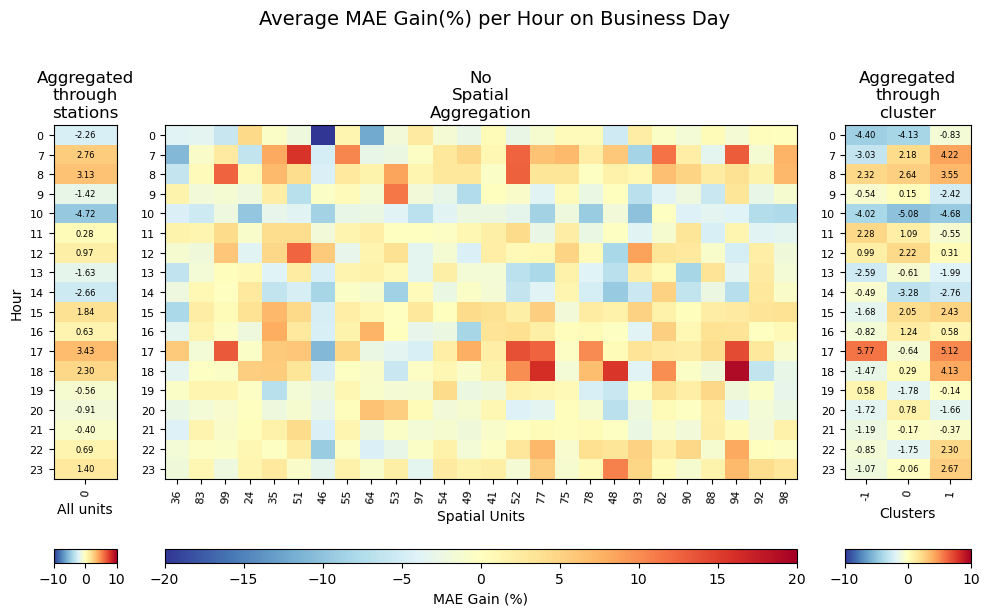

Figure saved in save/plot/Exp4_15min/mae/desag_STAEformer_bike_out_subway_in_subway_out_calendar_early_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0__e80_h4_bis_gain.pdf
Figure saved in desag_STAEformer_bike_out_subway_in_subway_out_calendar_early_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0__e80_h4_bis.pdf

STAEformer_bike_out_calendar__e80_h4_:   All Steps RMSE = 4.92698, MAE = 3.08078, MASE = 0.56985, MAPE = 50.64162
STAEformer_bike_out_subway_in_subway_out_calendar_early_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0__e80_h4_:   All Steps RMSE = 4.98623, MAE = 3.11746, MASE = 0.57663, MAPE = 51.72145

Trial ID 1:  _STAEformer_bike_out_calendar__e80_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e80_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp4_15min/bike_out_STAEformer/best_models/STA

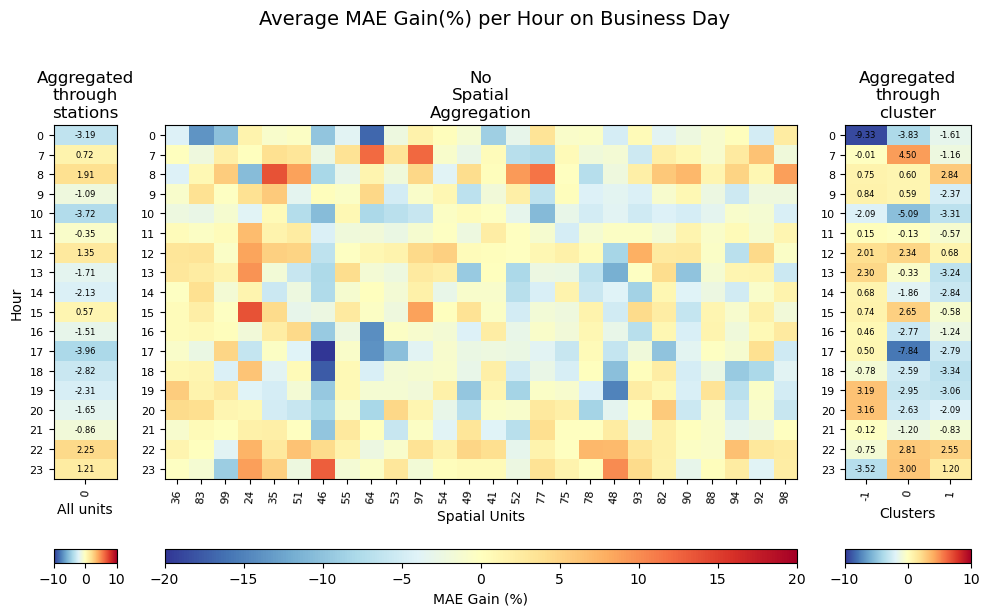

Figure saved in save/plot/Exp4_15min/mae/desag_STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e80_h4_bis_gain.pdf
Figure saved in desag_STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e80_h4_bis.pdf

STAEformer_bike_out_calendar__e80_h4_:   All Steps RMSE = 4.92698, MAE = 3.08078, MASE = 0.56985, MAPE = 50.64162
STAEformer_bike_out_subway_in_subway_out_calendar_early_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0__e80_h4_:   All Steps RMSE = 4.98623, MAE = 3.11746, MASE = 0.57663, MAPE = 51.72145
STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e80_h4_:   All Steps RMSE = 4.90011, MAE = 3.06680, MASE = 0.56726, MAPE = 50.25369

Trial ID 1:  _STAEformer_bike_out_calendar__e80_h4_bis1_f5
Trial ID 2:  _STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb12_

ValueError: Trial ID 2 _STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb12_ctxInEmb24_adp16_adpQ0__e80_h4_bis1_f5 not found in model_args

In [18]:
# ---- Plot Desagregated Gains : ----

# exp: 
#  'Exp3_bike_15min_h4',     # prediction Bike-out / Subway-out Weathr (h4)
#  'Exp4',                   # prediction bike-out / subway-in, subway-out (h1) avec freq = 60min 

# Prediction Bike-out : 
#  'Exp4_15min',             # prediction Bike-out / subway-in,subway-out (h4)
#  'Exp4_15min_h1',          # prediction Bike-out / subway-in,subway-out (h1)


#  'Exp6_subway_netmob',
#  'Exp6_bike_netmob']
from experiences.common_results import dic_exp_to_names,dic_trials
from experiences.get_desagregated_plot import get_desagregated_gains
exp = 'Exp4_15min'
trials = [f'STAEformer_bike_out_subway_in_subway_out_calendar_{pos}_fusion_CrossAttnBackBone_InEmb{InEmb}_ctxInEmb{Ctx}_adp{Adp}_adpQ{Q}__e80_h4'
          for pos,InEmb,Ctx,Adp,Q in [('early',24,8,16,0),
                                  ('late',24,24,16,24),
                                  ('late',12,24,16,0),
                              ]]+ ['STAEformer_bike_out_calendar__e80_h4']

dic_trials = {exp:  trials
             # dic_trials[exp]
              }
dic_exp_to_names = {exp: dic_exp_to_names[exp]}
horizons = [4]
comparison_on_rainy_events = False
range_k = range(1,6)
station_clustering = True
folder_path = 'save'

get_desagregated_gains(dic_exp_to_names,dic_trials,horizons,comparison_on_rainy_events,range_k,station_clustering,folder_path,save_bool=True)

NameError: name 'model_args' is not defined

In [17]:

from examples.accuracy_comparison import get_model_args,get_desagregated_comparison_plot,get_previous
from experiences.common_results import find_baseline
from pipeline.utils.metrics import evaluate_metrics

def get_desagregated_gains(dic_exp_to_names,dic_trials,horizons,comparison_on_rainy_events,range_k,station_clustering,folder_path,save_bool = True):
    issue_while_loading_saved_weights,log = '', ''
    init_folder_path = f"{folder_path}/plot"
    for exp_i,target_model_name in dic_exp_to_names.items():
        target_data = '_'.join(target_model_name.split('_')[:-1])
        model_name = target_model_name.split('_')[-1]
        print(exp_i)
        configs = dic_trials[exp_i]
        print('config: ',configs)
        for h in horizons:
            print(f"\n--- Horizon h = {h} ---")
            baseline = find_baseline(exp_i,h=h)
            print('Baseline: ',baseline)
            if (baseline in configs) and baseline.endswith(f"_h{h}"):
                trial_ids2 = [f"{config}_bis" for config in configs if (config.endswith(f"_h{h}")) and not(baseline == config)]
                trial_ids1 = [f"{baseline}_bis"]*len(trial_ids2)

                if exp_i == 'Exp4_15min_h1':
                    exp_i = 'Exp4_15min'
                save_folder_name = f'{exp_i}/{target_data}_{model_name}'
                save_folder_name_bis = None

                model_args,model_args_bis,path_model_args,path_model_args_bis = get_model_args(save_folder_name,save_folder_name_bis)

                print('Trial id Ref: ',trial_ids1[0])
                print('Trial id to test: ')
                for trial_id in trial_ids2:
                    print(trial_id)

                for trial_id1,trial_id2 in zip(trial_ids1,trial_ids2):
                    if comparison_on_rainy_events:
                        folder_path = f"{init_folder_path}/{exp_i}_rainy"
                    else:
                        folder_path = f"{init_folder_path}/{exp_i}"
                    if save_bool:
                        save_name = f"desag_{trial_id2}"
                    else:
                        save_name = None
                    outputs = get_desagregated_comparison_plot(trial_id1,trial_id2,
                                                                model_args = model_args,
                                                                model_args_bis = model_args_bis,
                                                                path_model_args = path_model_args,
                                                                path_model_args_bis = path_model_args_bis,
                                                                range_k = range_k,
                                                                trial_id1_in_bis=False,
                                                                trial_id2_in_bis=False,
                                                                comparison_on_rainy_events = comparison_on_rainy_events ,
                                                                station_clustering = station_clustering,
                                                                folder_path = folder_path,
                                                                save_name = save_name,
                                                                )
                    clusterer,full_predict1,full_predict2,train_input,X,Y_true,L_trainers_1,L_trainers_2,ds1,ds2,args_init1,args_init2,rainy_indices,rainy_mask = outputs

                    if full_predict1 is None:
                        issue_while_loading_saved_weights +=  f"\nProblem for {trial_id1} vs {trial_id2} in {exp_i}"
                    print(issue_while_loading_saved_weights)

                    h_idx = args_init2.step_ahead // args_init2.horizon_step
                    previous = get_previous(X,Y_true,h_idx)

                    if comparison_on_rainy_events :
                        full_predict1 = torch.index_select(full_predict1,0,rainy_indices)
                        full_predict2 = torch.index_select(full_predict2,0,rainy_indices)
                        Y_true = torch.index_select(Y_true,0,rainy_indices)
                        previous = torch.index_select(previous,0,rainy_indices)

                    RMSE1,MAE1,MASE1,MAPE1 = [],[],[],[]
                    RMSE2,MAE2,MASE2,MAPE2 = [],[],[],[]
                    for n_bis in range(full_predict1.size(-1)):
                        full_predict1_i = full_predict1[...,n_bis] 
                        full_predict2_i = full_predict2[...,n_bis] 
                        dic_metric1_i = evaluate_metrics(full_predict1_i,Y_true,metrics = ['rmse','mse','mae','mase','mape'], previous = previous,horizon_step = h_idx)
                        dic_metric2_i = evaluate_metrics(full_predict2_i,Y_true,metrics = ['rmse','mse','mae','mase','mape'], previous = previous,horizon_step = h_idx)
                        RMSE1.append(dic_metric1_i['rmse_all'])
                        MAE1.append(dic_metric1_i['mae_all'])
                        MASE1.append(dic_metric1_i['mase_all'])
                        MAPE1.append(dic_metric1_i['mape_all'])
                        RMSE2.append(dic_metric2_i['rmse_all'])
                        MAE2.append(dic_metric2_i['mae_all'])
                        MASE2.append(dic_metric2_i['mase_all'])
                        MAPE2.append(dic_metric2_i['mape_all'])
                    RMSE1 = np.mean(np.array(RMSE1))
                    MAE1 = np.mean(np.array(MAE1))
                    MASE1 = np.mean(np.array(MASE1))
                    MAPE1 = np.mean(np.array(MAPE1))
                    RMSE2 = np.mean(np.array(RMSE2))
                    MAE2 = np.mean(np.array(MAE2))
                    MASE2 = np.mean(np.array(MASE2))
                    MAPE2 = np.mean(np.array(MAPE2))


                    if log == '':
                        log += f"{trial_id1[:-3]}:   All Steps RMSE = {RMSE1:.5f}, MAE = {MAE1:.5f}, MASE = {MASE1:.5f}, MAPE = {MAPE1:.5f}\n"
                    log += f"{trial_id2[:-3]}:   All Steps RMSE = {RMSE2:.5f}, MAE = {MAE2:.5f}, MASE = {MASE2:.5f}, MAPE = {MAPE2:.5f}\n"
                    print(log)



get_desagregated_gains(dic_exp_to_names,dic_trials,horizons,comparison_on_rainy_events,range_k,station_clustering,folder_path,save_bool=True)

Exp4_15min
config:  ['STAEformer_bike_out_subway_in_subway_out_calendar_early_fusion_CrossAttnBackBone_InEmb24_ctxInEmb8_adp16_adpQ0__e80_h4', 'STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24__e80_h4', 'STAEformer_bike_out_subway_in_subway_out_calendar_late_fusion_CrossAttnBackBone_InEmb12_ctxInEmb24_adp16_adpQ0__e80_h4']

--- Horizon h = 4 ---
Baseline:  STAEformer_bike_out_calendar__e80_h4


# Others

In [6]:
# --- Captions Dictionary ---
captions = {
    "Exp1": r"Prediction of Subway-Out with STAEformer using contextual data 'Subway-In' according to different Integration Strategies. Metrics are averaged over 5 runs.",
    "Exp1_subway_in": r"Prediction of Subway-In with STAEformer using contextual data 'Subway-Out' according to different Integration Strategies. Metrics are averaged over 5 runs.",
    "Exp2": r"Prediction of Bike-Out (15min aggregation) at a 60-minute horizon with STAEformer, using weather forecasts as contextual data. Metrics are averaged over 5 runs.",
    "Exp4": r"Prediction of Bike-Out with STAEformer using heterogenous contextual data 'subway-in-subway-out' (1h aggregation) at horizon +60min. The table compares the baseline with different configurations of the CrossAttnBackBone model. Metrics are averaged over 5 runs.",
    "Exp4_15min": r"Prediction of Bike-Out with STAEformer using heterogenous contextual data 'subway-in-subway-out' (15min aggregation) at horizon +60min. This table compares various CrossAttnBackBone model configurations. Metrics are averaged over 5 runs.",
     "Exp4_15min_h1": r"Prediction of Bike-Out with STAEformer using heterogenous contextual data 'subway-in-subway-out' (15min aggregation) at horizon +15min. This table compares various CrossAttnBackBone model configurations. Metrics are averaged over 5 runs.",
}

# --- Generate and Print LaTeX Tables ---
print("%%% LaTeX code for Experiment 1 Table %%%\n")
latex_table_1 = dataframe_to_latex(df_metrics_Exp1_h4, captions["Exp1"], "exp1_subway_context", parse_index_exp1_2)
print(latex_table_1)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 1 Horizon +15min Table %%%\n")
latex_table_1 = dataframe_to_latex(df_metrics_Exp1_subway_in_h1, captions["Exp1_subway_in"], "exp1_subway_context", lambda x: parse_index_exp1_2(x, contextual='subway_out'))
print(latex_table_1)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 1 Horizon +60min Table %%%\n")
latex_table_1 = dataframe_to_latex(df_metrics_Exp1_subway_in_h4, captions["Exp1_subway_in"], "exp1_subway_context", lambda x: parse_index_exp1_2(x, contextual='subway_out'))
print(latex_table_1)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 2 Table %%%\n")
# Note: parse_index_exp1_2 is reused as it correctly handles the index format for Exp2
latex_table_2 = dataframe_to_latex(df_metrics_Exp2_h4, captions["Exp2"], "exp2_bike_weather", parse_index_exp1_2)
print(latex_table_2)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 4 Table %%%\n")
latex_table_4 = dataframe_to_latex(df_metrics_Exp4_h1, captions["Exp4"], "exp4_bike_hetero", parse_index_exp4)
print(latex_table_4)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 4 (15min) at horizon +60min Table %%%\n")
# Note: parse_index_exp4 is reused as it correctly handles the index format for Exp4_15min
latex_table_4_15min = dataframe_to_latex(df_metrics_Exp4_15min_h4, captions["Exp4_15min"], "exp4_bike_hetero_15min", parse_index_exp4)
print(latex_table_4_15min)

print("\n" + "="*80 + "\n")

print("\n------------------------------------------------\n%%% LaTeX code for Experiment 4 (agg 15min) at horizon + 15min Table %%%\n")
latex_table_4_15min_h1 = dataframe_to_latex(df_metrics_Exp4_15min_h4, captions["Exp4_15min_h1"], "exp4_bike_hetero_15min", parse_index_exp4)
print(latex_table_4_15min_h1)

print("\n" + "="*80 + "\n")


%%% LaTeX code for Experiment 1 Table %%%



NameError: name 'df_metrics_Exp1_h4' is not defined

In [22]:

import os 
import sys 

current_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.accuracy_comparison import load_trainer_ds_from_2_trials,get_predict_real_and_inputs,get_model_args
from examples.accuracy_comparison import get_rainy_indices,plot_analysis_comparison_2_config,get_previous_and_prediction,get_gain_from_mod1
import torch 
from pipeline.utils.metrics import evaluate_metrics

def get_dict_metrics_on_rainy_events(full_predict1,full_predict2,Y_true,X,args_init1,args_init2,ds2):
    h_idx = 1
    metric_list = ['rmse','mse','mae','mase','mape']
    previous,_,_,_ = get_previous_and_prediction(full_predict1,full_predict2,Y_true,X,h_idx)
    assert args_init1.horizon_step == args_init1.step_ahead, "Horizon step must be equal to step_ahead here"

    print("\nComparison on between models across all time-slots followed by comparison on Rainy Events Only")
    _,train_rainy_indices,_ = get_rainy_indices(args = args_init2,ds = ds2,training_mode = 'train')
    print(f"Number of rainy time-slots in the train set: {len(train_rainy_indices)}, i.e {len(train_rainy_indices)/len(ds2.tensor_limits_keeper.df_verif_train)*100:.2f} % of the train set")
    # ---- Plot Accuracy comparison on rainy moments only ----
    mask,rainy_indices,df_weather = get_rainy_indices(args = args_init2,ds = ds2,training_mode = 'test')
    print(f"Number of rainy time-slots in the test set: {len(rainy_indices)}, i.e {len(rainy_indices)/len(ds2.tensor_limits_keeper.df_verif_test)*100:.2f} % of the test set\n")

    dates = mask[mask].index
    masked_index = mask.reset_index(drop=True)
    masked_index = masked_index[masked_index].index


    # --- Get Prediction on rainy time-slots:
    rainy_predict1 = torch.index_select(full_predict1,0,torch.tensor(masked_index).long())
    rainy_predict2 = torch.index_select(full_predict2,0,torch.tensor(masked_index).long())
    rainy_Y_true = torch.index_select(Y_true,0,torch.tensor(masked_index).long())
    rainy_previous = torch.index_select(previous,0,torch.tensor(masked_index).long())

    dic_metric1 = evaluate_metrics(rainy_predict1,rainy_Y_true,metrics = metric_list, previous = rainy_previous,horizon_step = h_idx)
    dic_metric1 = dict(dic_metric1.copy())
    dic_metric2 = evaluate_metrics(rainy_predict2,rainy_Y_true,metrics = metric_list, previous = rainy_previous,horizon_step = h_idx)
    dic_metric2 = dict(dic_metric2.copy())
    return dic_metric1,dic_metric2



dic_contextual_data = {'bike_out': [[]],  #,['weather','calendar']
                    }

dic_fusion_strategie = {('bike_out',()): [''],
                        ('bike_out',('weather','calendar')):['early_fusion','late_fusion'],
                        }
             
dic_feature_extractor = {('bike_out',()): [''],
                        ('bike_out',('weather','calendar')):['repeat_t_proj','feature_extractor']
                        }


model_name = 'STAEformer'
epochs = 200
range_k = range(1,6)
training_mode = 'test'
modification = {'shuffle':False,
                'data_augmentation':False,
                'torch_compile': False,
                }
log = ''
Exp = 'Exp2'  # 'Exp2'

for horizon in [4]:
    for target in ['bike_out']:
        for contextual_data in dic_contextual_data[target]:
            reversed_metric = False
            fusion_strategies = dic_fusion_strategie[(target,tuple(contextual_data))]
            for fusion_strategie in fusion_strategies:
                feature_extractors = dic_feature_extractor[(target,tuple(contextual_data))]
                for feature_extractor in feature_extractors:
                    if not('weather' in contextual_data):
                        print('\n------------------------------------------------------\nContextual data:\n')
                        contextual_data1 = ['weather','calendar'] if target == 'bike_out' else ['subway_in','weather','calendar']
                        fusion_strategie1 = dic_fusion_strategie[(target,tuple(contextual_data1))][0]
                        feature_extractor1 = dic_feature_extractor[(target,tuple(contextual_data1))][0]

                        trial_id1 = f"{model_name}_{target}_calendar__e{epochs}_h{horizon}_bis"
                        trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data1)}_{fusion_strategie1}_{feature_extractor1}__e{epochs}_h{horizon}_bis"
                        reversed_metric = True 
                    else:
                        trial_id1 = f"{model_name}_{target}_calendar__e{epochs}_h{horizon}_bis"
                        trial_id2 = f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}__e{epochs}_h{horizon}_bis"

                    model_args,_,path_model_args,_ = get_model_args(target,model_name,save_folder_name = f'{Exp}/{target}_{model_name}')
                    ds1,ds2,args_init1,args_init2 = None, None, None, None
                    for k in range_k:
                        trial_id1_updated = f"{trial_id1}{k}_f5"
                        trial_id2_updated = f"{trial_id2}{k}_f5"

                        trainer1,trainer2,ds1,ds2,args_init1,args_init2 = load_trainer_ds_from_2_trials(trial_id1_updated,trial_id2_updated,modification = modification,
                                                                                                        model_args=model_args,
                                                                                                        path_model_args=path_model_args,
                                                                                                        ds1_init=ds1,ds2_init=ds2,
                                                                                                        args_init1=args_init1,args_init2=args_init2,
                                                                                                        )
                                                                                                        

                        full_predict1,full_predict2,Y_true,X = get_predict_real_and_inputs(trainer1,trainer2,ds1,ds2,training_mode=training_mode)

                        globals()[f"trainer1_bis{k}"] = trainer1
                        globals()[f"trainer2_bis{k}"] = trainer2
                        globals()[f"ds1_bis{k}"] = ds1
                        globals()[f"ds2_bis{k}"] = ds2
                        globals()[f"full_predict1_bis{k}"] = full_predict1
                        globals()[f"full_predict2_bis{k}"] = full_predict2

                        dic_metric1,dic_metric2 = get_dict_metrics_on_rainy_events(globals()[f"full_predict1_bis{k}"],globals()[f"full_predict2_bis{k}"],Y_true,X,args_init1,args_init2,ds2)

                        # Keep track on metric from model 1
                        if reversed_metric:
                            dic_metric2 = dict(dic_metric1.copy())
                        RMSE = dic_metric2['rmse_all']
                        MAE = dic_metric2['mae_all']
                        MASE = dic_metric2['mase_all']
                        MAPE = dic_metric2['mape_all']
                        if feature_extractor == []:
                            log += f"{model_name}_{target}__e{epochs}_h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.3f}, MAE = {MAE:.3f}, MASE = {MASE:.3f}, MAPE = {MAPE:.3f}\n"
                        else:
                            log += f"{model_name}_{target}_{'_'.join(contextual_data)}_{fusion_strategie}_{feature_extractor}__e{epochs}_h{horizon}_bis{k}:   All Steps RMSE = {RMSE:.3f}, MAE = {MAE:.3f}, MASE = {MASE:.3f}, MAPE = {MAPE:.3f}\n"

                    print(log)


------------------------------------------------------
Contextual data:

Trial ID 1:  STAEformer_bike_out_calendar__e200_h4_bis1_f5
Trial ID 2:  STAEformer_bike_out_weather_calendar_early_fusion_repeat_t_proj__e200_h4_bis1_f5
model_save_path for trial id1:  /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp2/bike_out_STAEformer/best_models/STAEformer_bike_out_calendar__e200_h4_bis1_f5.pkl
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 35040 elts between 2019-01-01 00:00:00 and 2019-12-31 23:45:00
Invalid dates within this fold: 0

>>>Tackle Target dataset: bike_out
Loading from /home/rrochas/../../data/rrochas/prediction_validation/agg_data/velov/velov_emitted_by_station15min.csv...
df pivoted:  (70049, 434)
df reindexed :  (35040, 434)
Len coverage period:  35040
df filtered:  (35040, 434)
   Loaded data: (35040, 434)
   Dimension after spatial agg: (35040, 26)
   Init Dataset: 'torch.Size(